# PSCDB - Processing

Here, we scrape [PSCDB (Protein Structural Change Database)](http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/index.html)

In [3]:
%matplotlib inline
import logging
logging.basicConfig(level=logging.CRITICAL)

import pandas as pd
import rdkit
from Bio.PDB import PDBList
from tqdm import tqdm

[23:36:02] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [23:36:02] Enabling RDKit 2019.09.3 jupyter extensions


In [4]:
coupled_domain_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/cd.html", header=0)[0]
coupled_domain_motion['motion_type'] = 'coupled_domain_motion'

independent_domain_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/id.html", header=0)[0]
independent_domain_motion['motion_type'] = 'independent_domain_motion'

coupled_local_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/cl.html", header=0)[0]
coupled_local_motion['motion_type'] = 'coupled_local_motion'

independent_local_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/il.html", header=0)[0]
independent_local_motion['motion_type'] = 'independent_local_motion'

burying_ligand_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/b.html", header=0)[0]
burying_ligand_motion['motion_type'] = 'burying_ligand_motion'

no_significant_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/n.html", header=0)[0]
no_significant_motion['motion_type'] = 'no_significant_motion'

other_motion = pd.read_html("http://idp1.force.cs.is.nagoya-u.ac.jp/pscdb/b.html", header=0)[0]
other_motion['motion_type'] = 'other_motion'

structural_rearrangement_data = pd.concat([coupled_domain_motion, independent_domain_motion,
                                           coupled_local_motion, independent_local_motion,
                                           burying_ligand_motion, no_significant_motion, other_motion]).reset_index()

structural_rearrangement_data.head()

,index,PSCID,Protein Name,Free form,Bound form,Ligands,Classification(?),motion_type
0,0,CD.1,HYPOTHETICAL OXIDOREDUCTASE YIAK,1nxu_AB,1s20_AB,"2xNAD,2xTLA",200004,coupled_domain_motion
1,1,CD.2,ADENYLATE KINASE,4ake_A,2eck_A,"ADP,AMP",200003,coupled_domain_motion
2,2,CD.3,GLUCOKINASE,1q18_AB,1sz2_AB,2xBGC,200003,coupled_domain_motion
3,3,CD.4,LACTOFERRIN,1lfh_A,1lfi_A,"2xCU,2xNAG",110103,coupled_domain_motion
4,4,CD.5,ELONGATION FACTOR 2,1n0v_D,1n0u_A,SO1,110002,coupled_domain_motion


## Data Processing
Here we perform processing steps, extracing the relevant protein chains and PDB accessions

Some PDB structures are made obsolete over time. We remove these

In [5]:
# Split into chains
free_structures = structural_rearrangement_data['Free form'].str.split('_', expand=True)
bound_structures = structural_rearrangement_data['Bound form'].str.split('_', expand=True)

# Add columns
structural_rearrangement_data['Free PDB'] = free_structures[0]
structural_rearrangement_data['Free Chains'] = free_structures[1]
structural_rearrangement_data['Bound PDB'] = bound_structures[0]
structural_rearrangement_data['Bound Chains'] = bound_structures[1]

# Drop obsolete structures
obsolete = ['1m80', '1cmw', '1g40', '2ihi', '1hl0', '2gkq', '2glb', '2g2j', '2dpo', '2h98', '2gu9', '2bg1', '1q4o', '1il5', '3cey', '1yks']
structural_rearrangement_data = structural_rearrangement_data.loc[~structural_rearrangement_data['Free PDB'].isin(obsolete)]
structural_rearrangement_data = structural_rearrangement_data.loc[~structural_rearrangement_data['Bound PDB'].isin(obsolete)]

#structural_rearrangement_data.reset_index(inplace=True)

# Uncomment the next line to save the data as a CSV
# structural_rearrangement_data.to_csv('structural_rearrangement_data.csv')
structural_rearrangement_data.head()

,index,PSCID,Protein Name,Free form,Bound form,Ligands,Classification(?),motion_type,Free PDB,Free Chains,Bound PDB,Bound Chains
0,0,CD.1,HYPOTHETICAL OXIDOREDUCTASE YIAK,1nxu_AB,1s20_AB,"2xNAD,2xTLA",200004,coupled_domain_motion,1nxu,AB,1s20,AB
1,1,CD.2,ADENYLATE KINASE,4ake_A,2eck_A,"ADP,AMP",200003,coupled_domain_motion,4ake,A,2eck,A
2,2,CD.3,GLUCOKINASE,1q18_AB,1sz2_AB,2xBGC,200003,coupled_domain_motion,1q18,AB,1sz2,AB
3,3,CD.4,LACTOFERRIN,1lfh_A,1lfi_A,"2xCU,2xNAG",110103,coupled_domain_motion,1lfh,A,1lfi,A
4,4,CD.5,ELONGATION FACTOR 2,1n0v_D,1n0u_A,SO1,110002,coupled_domain_motion,1n0v,D,1n0u,A


### Download PDBs
Optionally, you can download the PDB files using the code block below. This is not necessary for downstream usage with Graphein as we can construct graphs based on the PDB accession codes.

In [ ]:
pdbl = PDBList()
pdb_list = pd.concat([structural_rearrangement_data['Free PDB'], structural_rearrangement_data['Bound PDB']]).unique()

pdbl.download_pdb_files(pdb_list, obsolete=False, pdir='pdbs/', file_format='pdb', overwrite=True)

#Rename PDB files from .ent to .pdb\n
!cd pdbs/; for f in *.ent; do mv -- "$f" "${f%.ent}.pdb"; done
# Remove pdb prefix from PDB file names (e.g. pdb20jj.ent -> 20jj.pdb)\n",
!cd pdbs/; for x in *; do mv $x `echo $x | cut -c 4-`; done

## Make Graphs!

Now we make some beautiful protein structure graphs for a subset of the data!

In [13]:
## Make Graphs
import networkx as nx
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_hydrophobic_interactions

config = ProteinGraphConfig(edge_construction_funcs=[add_hydrogen_bond_interactions, add_hydrophobic_interactions, add_ionic_interactions])

In [15]:
free_graphs = {}

BAD_PDBS = []
for i in tqdm(range(10)):
    pscid = structural_rearrangement_data.iloc[i]["PSCID"]
    
    free_pdb = structural_rearrangement_data.iloc[i]["Free PDB"]
    free_chain = structural_rearrangement_data.iloc[i]["Free Chains"]
    try:
        free_graphs[pscid] = construct_graph(pdb_code=free_pdb, chain_selection=free_chain, config=config)
    except:
        BAD_PDBS.append(free_pdb)

 10%|███████████                                                                                                   | 1/10 [00:02<00:22,  2.50s/it]

 20%|██████████████████████                                                                                        | 2/10 [00:03<00:14,  1.87s/it]

 30%|█████████████████████████████████                                                                             | 3/10 [00:05<00:13,  1.89s/it]

 40%|████████████████████████████████████████████                                                                  | 4/10 [00:07<00:10,  1.70s/it]

 50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:09<00:08,  1.77s/it]

 60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:11<00:07,  1.87s/it]

 70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:13<00:06,  2.15s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:15<00:03,  1.81s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:16<00:01,  1.64s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]

In [16]:
bound_graphs = {}    
for i in tqdm(range(10)):
    pscid = structural_rearrangement_data.iloc[i]["PSCID"]
    
    bound_pdb = structural_rearrangement_data.iloc[i]["Bound PDB"]
    bound_chain = structural_rearrangement_data.iloc[i]["Bound Chains"]
    
    bound_graphs[pscid] = construct_graph(pdb_code=bound_pdb, chain_selection=bound_chain, config=config)

 10%|███████████                                                                                                   | 1/10 [00:03<00:35,  4.00s/it]

 20%|██████████████████████                                                                                        | 2/10 [00:05<00:20,  2.54s/it]

 30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:14,  2.10s/it]

 40%|████████████████████████████████████████████                                                                  | 4/10 [00:08<00:10,  1.69s/it]

 50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:09<00:08,  1.60s/it]

 60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:11<00:06,  1.59s/it]

 70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:12<00:04,  1.51s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:14<00:03,  1.76s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:15<00:01,  1.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]

### Let's check them out!

/home/atj39/github/graphein/graphein/protein/visualisation.py:326: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  # 3D network plot
/home/atj39/github/graphein/graphein/protein/visualisation.py:326: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  # 3D network plot


<Axes3D:>

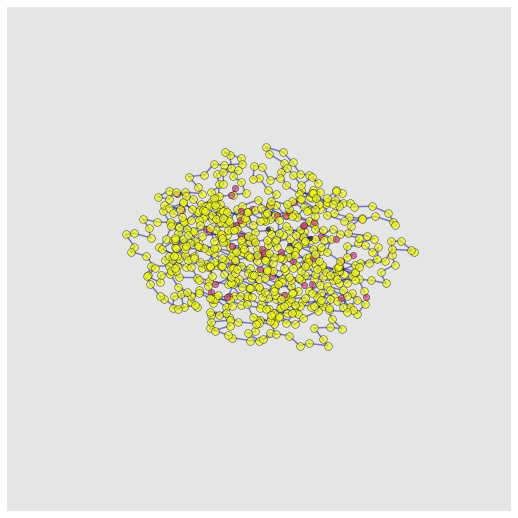

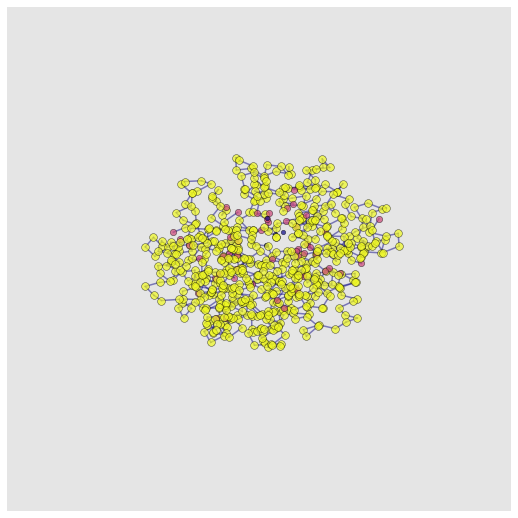

In [27]:
import matplotlib.pyplot as plt
from graphein.protein.visualisation import plot_protein_structure_graph

plot_protein_structure_graph(free_graphs["CD.1"], angle=30, colour_edges_by = "kind", label_node_ids=False)
plot_protein_structure_graph(bound_graphs["CD.1"], angle=30, colour_edges_by = "kind", label_node_ids=False)